# Higgs Boson Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Data
The [dataset is obtained from UCI](https://archive.ics.uci.edu/ml/datasets/HIGGS) and contains 21 features measured by detectors in an accelerator and the last 7 are generated based on the first 21 and consists of 11000000 rows. The `label` colum contains label which is 1 for the boson and 0 for background noise.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-04-28 15:50:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G   101MB/s    in 27s     

2021-04-28 15:51:26 (98.7 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [ ]:
!gzip -d HIGGS.csv.gz

The columns are: label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb.

In [ ]:
columns = ["label","lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]
df = pd.read_csv("HIGGS.csv", names=columns)
df.head()

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [ ]:
df.shape

(11000000, 29)

Sample only 3% of the whole data and use only generated feature. The full data set and all features will be explored using Apache Spark.

In [ ]:
synthetic_df = df.iloc[:, 22:].copy()
synthetic_df["label"] = df["label"]
sample_df = synthetic_df.sample(frac=0.03, random_state=1)

## Exploratory Data Analysis

In [ ]:
sample_df.describe().T

,count,mean,std,min,25%,50%,75%,max
m_jj,330000.0,1.032526,0.676221,0.075070,0.789949,0.894591,1.023924,23.905035
m_jjj,330000.0,1.023821,0.380956,0.298855,0.845418,0.950721,1.083120,12.174695
m_lv,330000.0,1.050750,0.165726,0.091056,0.985755,0.989779,1.020394,5.520823
m_jlv,330000.0,1.010015,0.397183,0.157473,0.767731,0.917305,1.143385,8.266503
m_bb,330000.0,0.974177,0.525668,0.056099,0.674886,0.874249,1.139110,9.784142
m_wbb,330000.0,1.032752,0.364964,0.337903,0.819622,0.947605,1.139915,8.096107
m_wwbb,330000.0,0.959685,0.312603,0.370081,0.770463,0.872114,1.058541,5.726346
label,330000.0,0.528982,0.499160,0.000000,0.000000,1.000000,1.000000,1.000000


The sampled data set does not contain any missing values.

In [ ]:
sample_df.isnull().sum()

m_jj      0
m_jjj     0
m_lv      0
m_jlv     0
m_bb      0
m_wbb     0
m_wwbb    0
label     0
dtype: int64

In [ ]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330000 entries, 5620115 to 5213957
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   m_jj    330000 non-null  float64
 1   m_jjj   330000 non-null  float64
 2   m_lv    330000 non-null  float64
 3   m_jlv   330000 non-null  float64
 4   m_bb    330000 non-null  float64
 5   m_wbb   330000 non-null  float64
 6   m_wwbb  330000 non-null  float64
 7   label   330000 non-null  float64
dtypes: float64(8)
memory usage: 22.7 MB


The sampled data set contains comparable numbers of both labels.

In [ ]:
sample_df["label"].value_counts()

1.0    174564
0.0    155436
Name: label, dtype: int64

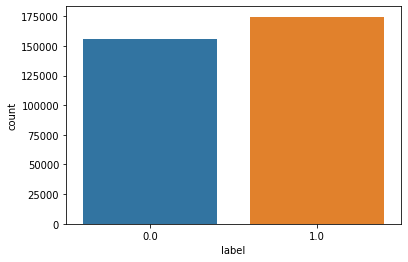

In [ ]:
sns.countplot(x="label", data=sample_df)
plt.show()

Some generated features are correlated as can be seen from pair scatter plots and correlation heat map below. Namely the Pearson correlation coefficient for `m_jjj` and `m_jj` is 0.8 and `m_wbb` and `m_wwbb` is 0.89.

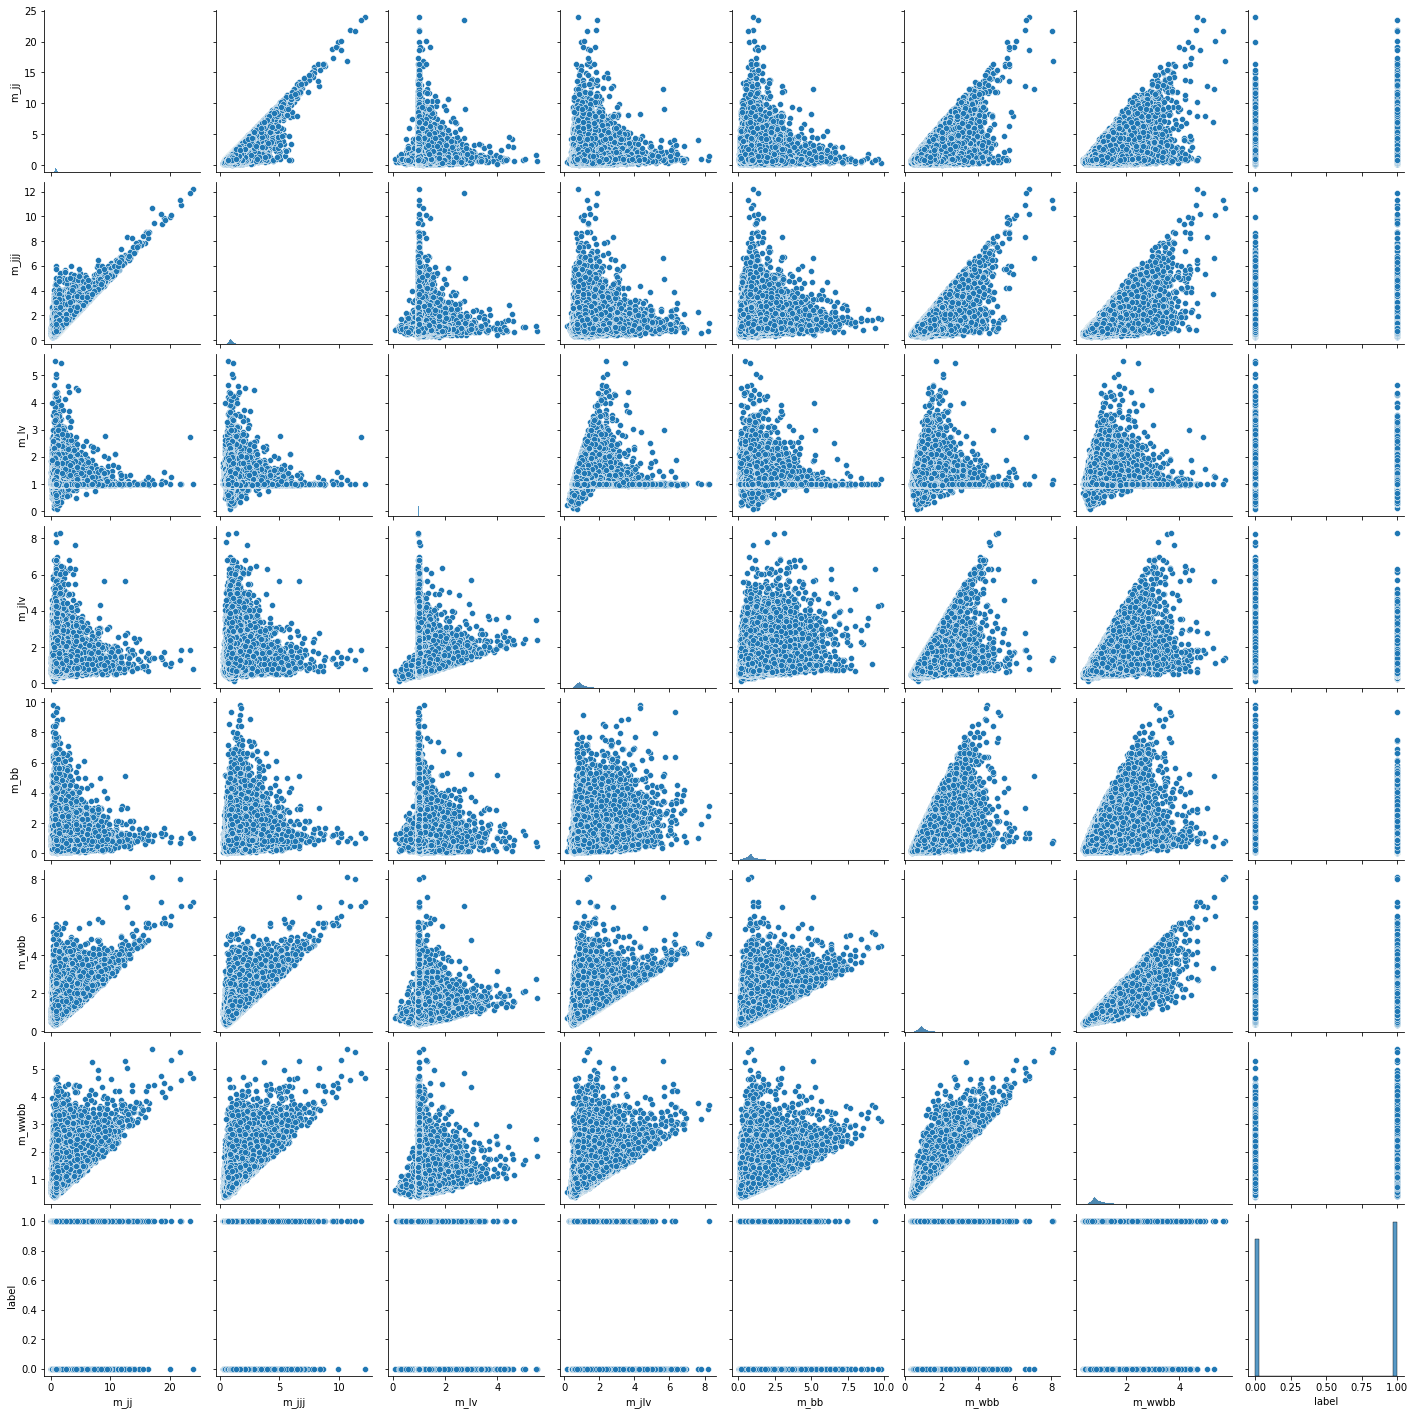

In [ ]:
sns.pairplot(data=sample_df)
plt.show()

In [ ]:
correlation = sample_df.corr()

In [ ]:
!curl -O https://raw.githubusercontent.com/javaeeeee/MachineLearningNotebooks/main/utils.ipynb
%run utils.ipynb

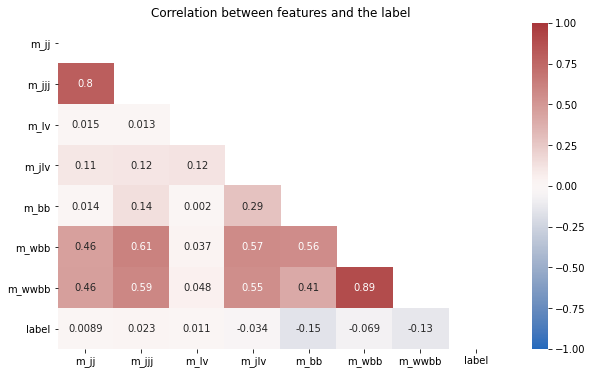

In [ ]:
plot_correlation_between_features(correlation, 10, 6)

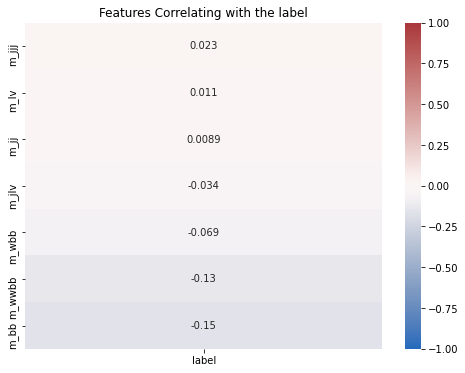

In [ ]:
plot_correlation_with_target(correlation, 8, 6, "label")

In [ ]:
X = sample_df.iloc[:, :7]
y = sample_df.iloc[:, -1:]
X_train, X_test, y_train, y_test = (train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=1))

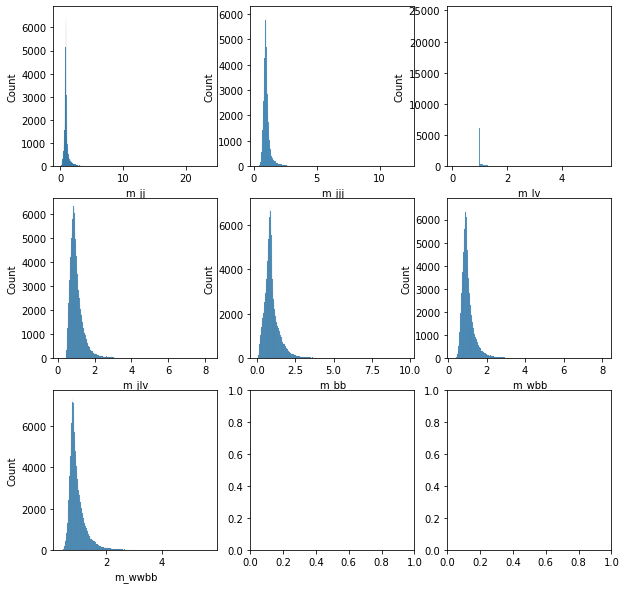

In [ ]:
plot_distributions(sample_df, 3, 3, 7, 10, 10)

Let's try [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) (RFE)

In [ ]:
# Remove correlated features
X_train_clean = X_train.drop(columns=["m_wwbb", "m_jjj"])
X_test_clean = X_test.drop(columns=["m_wwbb", "m_jjj"])

In [ ]:
# Scale features
columns = X_train_clean.columns
scaler = MinMaxScaler() 
X_train_clean = pd.DataFrame(scaler.fit_transform(X_train_clean), columns  = columns)
X_test_clean = pd.DataFrame(scaler.transform(X_test_clean), columns  = columns)

In [ ]:
estimator = LogisticRegression()
# Half features are selected by default
selector = RFE(estimator=estimator, n_features_to_select=3)
selector = selector.fit(X_train_clean, y_train.values.ravel())
selector.support_

array([False,  True, False,  True,  True])

In [ ]:
columns_selected = X_train_clean.columns[selector.support_]
columns_selected

Index(['m_lv', 'm_bb', 'm_wbb'], dtype='object')

In [ ]:
selector.ranking_

array([2, 1, 3, 1, 1])

In [ ]:
X_train_new = X_train_clean[columns_selected]
X_test_new = X_test_clean[columns_selected]

In [ ]:
model = LogisticRegression()
model.fit(X_train_new, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = model.predict(X_test_new)
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
accuracy

0.605560606060606

Confusion Matrix

In [ ]:
cmatrix = confusion_matrix(y_true=y_test, y_pred=preds)
cmatrix

array([[10628, 20573],
       [ 5460, 29339]])

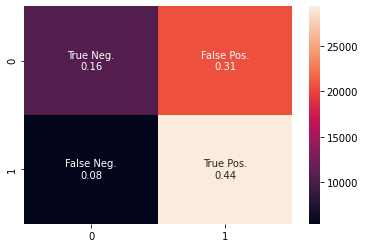

In [ ]:
def plot_confusion_matrix(conf_matrix):
  names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
  labels = (
      np.array(
        [f"{v1}\n{v2}" for v1, v2 in 
         zip(names, (conf_matrix.flatten()/conf_matrix.sum()).round(2))]
      )
      .reshape(2,2)
  )
  sns.heatmap(cmatrix, annot=labels, fmt='')
  plt.show()


plot_confusion_matrix(cmatrix)

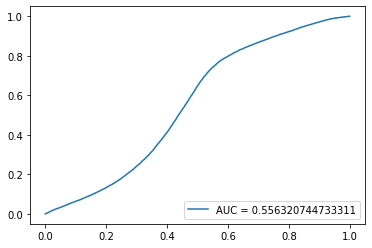

In [ ]:
def plot_roc_curve(X_test, y_test, model):
  probabilities = model.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  probabilities)
  auc = roc_auc_score(y_test, probabilities)
  plt.plot(fpr, tpr, label=f"AUC = {auc}")
  plt.legend(loc=4)
  plt.show()


plot_roc_curve(X_test_new, y_test, model)

In [ ]:
print(classification_report(y_true=y_test, y_pred=preds))

              precision    recall  f1-score   support

         0.0       0.66      0.34      0.45     31201
         1.0       0.59      0.84      0.69     34799

    accuracy                           0.61     66000
   macro avg       0.62      0.59      0.57     66000
weighted avg       0.62      0.61      0.58     66000



In [ ]:
# Scale all generated features
columns = X_train.columns
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [ ]:
regularized_model = LogisticRegression(penalty="l1", C=10, solver="liblinear")
regularized_model.fit(X_train_scaled, y_train.values.ravel())
y_pred = regularized_model.predict(X_test_scaled)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.6255454545454545

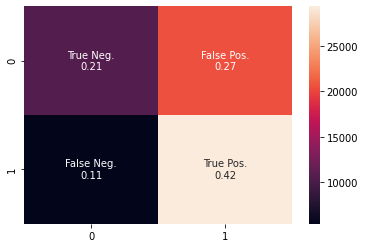

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

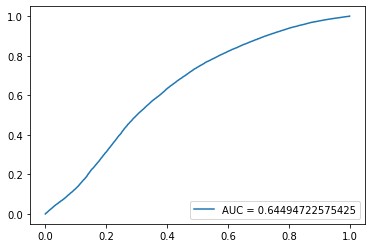

In [ ]:
plot_roc_curve(X_test_scaled, y_test, regularized_model)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.44      0.53     31201
         1.0       0.61      0.79      0.69     34799

    accuracy                           0.63     66000
   macro avg       0.63      0.62      0.61     66000
weighted avg       0.63      0.63      0.61     66000



Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
rf_preds = rf_model.predict(X_test)
accuracy_score(y_true=y_test, y_pred=rf_preds)

0.7019545454545455

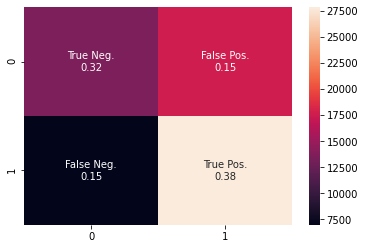

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=rf_preds))

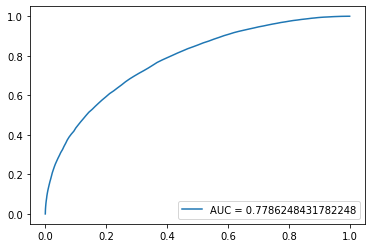

In [ ]:
plot_roc_curve(X_test, y_test, rf_model)

In [ ]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68     31201
         1.0       0.71      0.72      0.72     34799

    accuracy                           0.70     66000
   macro avg       0.70      0.70      0.70     66000
weighted avg       0.70      0.70      0.70     66000



In [ ]:
n_estimators = [int(val) for val in np.linspace(start=10, stop=200, num=10)]
max_features = ["sqrt", "log2", None]
min_samples_leaf = np.arange(1, 5)

In [ ]:
rfc = RandomForestClassifier()
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "min_samples_leaf": min_samples_leaf
}

rfc_optimizer = RandomizedSearchCV(estimator=rfc, 
                                   param_distributions=random_grid, 
                                   n_iter=10, 
                                   cv=3, 
                                   random_state=1)
rfc_optimizer.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rfc_optimizer.best_params_

{'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 157}

In [ ]:
optimized_preds = rfc_optimizer.predict(X_test)
accuracy_score(y_true=y_test, y_pred=optimized_preds)

0.7082424242424242

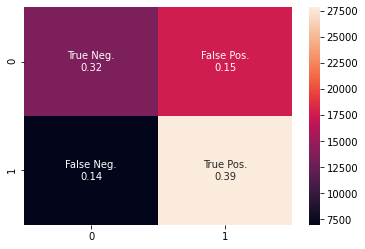

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=optimized_preds))

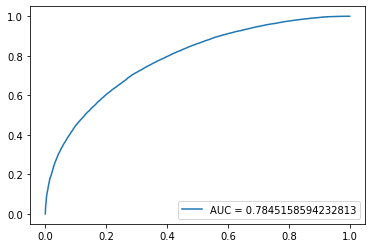

In [ ]:
plot_roc_curve(X_test, y_test, rfc_optimizer)

In [ ]:
print(classification_report(y_true=y_test, y_pred=optimized_preds))

              precision    recall  f1-score   support

         0.0       0.70      0.67      0.69     31201
         1.0       0.72      0.74      0.73     34799

    accuracy                           0.71     66000
   macro avg       0.71      0.71      0.71     66000
weighted avg       0.71      0.71      0.71     66000

